In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm

from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
#Transmit Power
P=1
#Power splitting ratio
rho = 1
#Power loss of splitter
eps = 1
#variance of antenna noise
w = 1
#rectifier efficiency
eta=1
noise_std = 1
print('number of symbols:',M)


number of symbols: 16


In [ ]:
def set_up_train_nn(P,EsNodB):
    
    label = np.random.randint(M,size=N)
    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)
        # checking data shape
    data = np.array(data)
    print (data.shape)
    es = EarlyStopping(monitor='val_loss',patience=15, verbose=1)
    #callbacks = [EarlyStoppingByAccuracy(monitor='accuracy', value=0.98, verbose=1)]
    # Defined Autoencoder
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded = Dense(8,activation='relu')(encoded)
    encoded = Dense(4,activation='relu')(encoded)
    encoded2 = Dense(n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = BatchNormalization(momentum=0,epsilon=1e-6,center=False,scale=False,axis=1)(encoded2)
    
    encoded4 = Lambda(lambda x: x*np.sqrt(P/2))(encoded3)

    #Add antenna noise
    encoded5 = Lambda(lambda x: x+K.random_normal_variable((2*4096,1), 0, 1)[0:tf.shape(x)[0],:])(encoded4)

    # Making PD data, and applying noise
    #pd_data = Lambda(lambda x: K.square(x))(encoded5)

    # Reciever Layer
    decoded = Dense(2, activation='relu')(encoded5)
    decoded = Dense(4,activation='relu')(decoded)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam = Adam(lr=0.075)
    epochs=65
   
    
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
    

    # traning auto encoder
    history = autoencoder.fit(data, data,epochs=epochs,batch_size=2*4096,callbacks=[es],validation_split=0.3)
    
    
    # list all data in history
    print(history.history.keys())
    
    results = autoencoder.evaluate(data, data, batch_size=2048)
    print('test loss, test acc:', results)

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded4)
    
    
    # for plotting learned consteallation diagram

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)
    
    # ploting constellation diagram
    
    

    plt.scatter([i for i in range(0,M)],scatter_plot)
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' P = '+str(P))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    p_av = np.sum(np.square(scatter_plot),axis=1)
    print(sum(p_av)/16)
    
    return autoencoder

(2000, 16)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1400 samples, validate on 600 samples
Epoch 1/65
1400/1400 [==============================] - 3s 2ms/step - loss: 2.7737 - acc: 0.1064 - val_loss: 2.6386 - val_acc: 0.1067
Epoch 2/65
1400/1400 [==============================] - 0s 22us/step - loss: 2.6930 - acc: 0.0950 - val_loss: 2.6940 - val_acc: 0.0883
Epoch 3/65
1400/1400 [==============================] - 0s 11us/step - loss: 2.6613 - acc: 0.1214 - val_loss: 2.6143 - val_acc: 0.1167
Epoch 4/65
1400/1400 [==============================] - 0s 11us/step - loss: 2.6597 - acc: 0.1150 - val_loss: 2.6068 - val_acc: 0.1150
Epoch 5/65
1400/1400 [==============================] - 0s 22us/step - loss: 2.6469 - acc: 0.1079 - val_loss: 2.5964 - val_acc: 0.1133
Epoch 6/65
1400/1400 [==============================] - 0s 11us/step - loss: 2.6284 - acc: 0.1193 - val_loss: 2.5819 - val_acc: 0.1217
Epoch 7/65
14

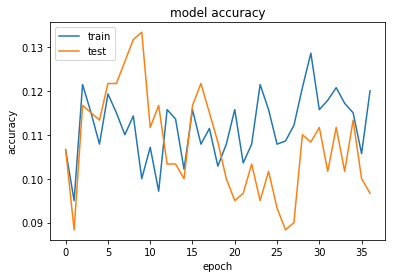

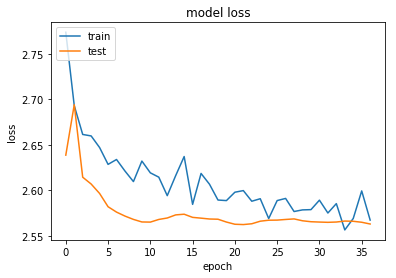

(16, 1, 1)


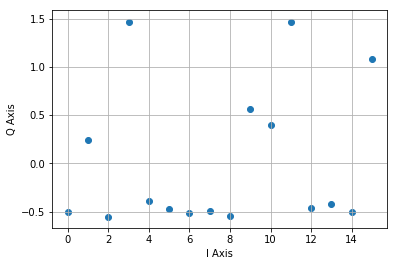

[0.5235776]
SNR: 0 SER: 0.890575 Theor_SER: 0.8232078436042176
(4000, 16)
Train on 2800 samples, validate on 1200 samples
Epoch 1/65
2800/2800 [==============================] - 3s 1ms/step - loss: 2.7732 - acc: 0.0586 - val_loss: 2.7359 - val_acc: 0.0975
Epoch 2/65
2800/2800 [==============================] - 0s 0us/step - loss: 2.7223 - acc: 0.1225 - val_loss: 2.6962 - val_acc: 0.1292
Epoch 3/65
2800/2800 [==============================] - 0s 6us/step - loss: 2.6923 - acc: 0.1368 - val_loss: 2.6643 - val_acc: 0.1275
Epoch 4/65
2800/2800 [==============================] - 0s 6us/step - loss: 2.6497 - acc: 0.1457 - val_loss: 2.6216 - val_acc: 0.1342
Epoch 5/65
2800/2800 [==============================] - 0s 6us/step - loss: 2.5959 - acc: 0.1436 - val_loss: 2.5772 - val_acc: 0.1383
Epoch 6/65
2800/2800 [==============================] - 0s 11us/step - loss: 2.5420 - acc: 0.1368 - val_loss: 2.5247 - val_acc: 0.1350
Epoch 7/65
2800/2800 [==============================] - 0s 6us/step - los

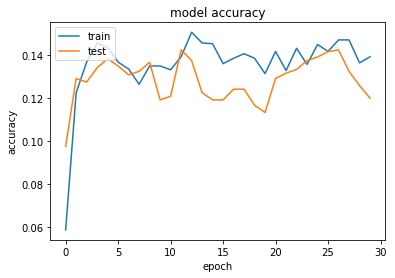

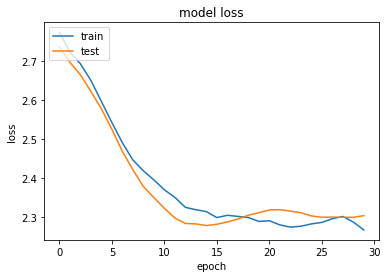

(16, 1, 1)


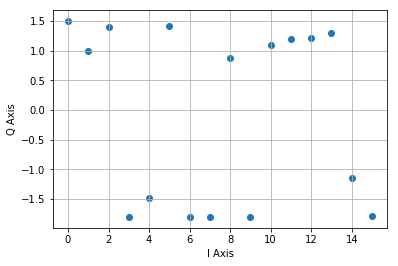

[2.0943623]
SNR: 6 SER: 0.89056 Theor_SER: 0.712087050228903
(8000, 16)
Train on 5600 samples, validate on 2400 samples
Epoch 1/65
5600/5600 [==============================] - 3s 497us/step - loss: 2.8354 - acc: 0.0630 - val_loss: 2.7606 - val_acc: 0.0338
Epoch 2/65
5600/5600 [==============================] - 0s 3us/step - loss: 2.7536 - acc: 0.0657 - val_loss: 2.7175 - val_acc: 0.1250
Epoch 3/65
5600/5600 [==============================] - 0s 6us/step - loss: 2.7246 - acc: 0.1118 - val_loss: 2.6824 - val_acc: 0.1200
Epoch 4/65
5600/5600 [==============================] - 0s 3us/step - loss: 2.6671 - acc: 0.1359 - val_loss: 2.6271 - val_acc: 0.1471
Epoch 5/65
5600/5600 [==============================] - 0s 6us/step - loss: 2.5967 - acc: 0.1470 - val_loss: 2.5449 - val_acc: 0.1596
Epoch 6/65
5600/5600 [==============================] - 0s 3us/step - loss: 2.5166 - acc: 0.1420 - val_loss: 2.4520 - val_acc: 0.1554
Epoch 7/65
5600/5600 [==============================] - 0s 3us/step - loss

Epoch 61/65
5600/5600 [==============================] - 0s 3us/step - loss: 1.7493 - acc: 0.2918 - val_loss: 1.7466 - val_acc: 0.2933
Epoch 62/65
5600/5600 [==============================] - 0s 6us/step - loss: 1.7543 - acc: 0.2991 - val_loss: 1.7455 - val_acc: 0.2879
Epoch 63/65
5600/5600 [==============================] - 0s 3us/step - loss: 1.7442 - acc: 0.3070 - val_loss: 1.7468 - val_acc: 0.2942
Epoch 64/65
5600/5600 [==============================] - 0s 3us/step - loss: 1.7449 - acc: 0.3009 - val_loss: 1.7471 - val_acc: 0.2904
Epoch 65/65
5600/5600 [==============================] - 0s 6us/step - loss: 1.7354 - acc: 0.2895 - val_loss: 1.7421 - val_acc: 0.2896
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
8000/8000 [==============================] - 0s 2us/step
test loss, test acc: [1.7443599767684936, 0.2927499978542328]


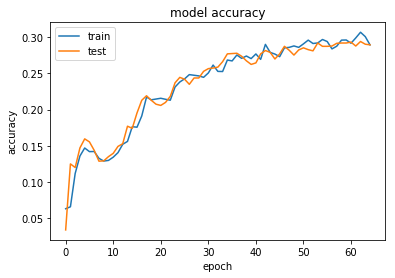

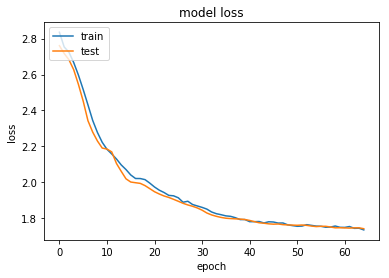

(16, 1, 1)


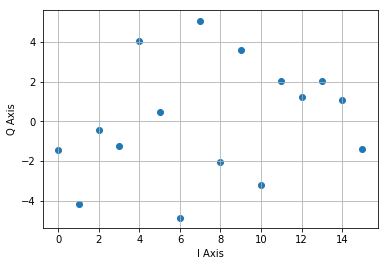

[7.9783797]
SNR: 12 SER: 0.7361 Theor_SER: 0.5075803579279314
(16000, 16)
Train on 11200 samples, validate on 4800 samples
Epoch 1/65
11200/11200 [==============================] - 3s 265us/step - loss: 2.8644 - acc: 0.0645 - val_loss: 2.7360 - val_acc: 0.1146
Epoch 2/65
11200/11200 [==============================] - 0s 4us/step - loss: 2.4981 - acc: 0.1265 - val_loss: 2.4348 - val_acc: 0.1231
Epoch 3/65
11200/11200 [==============================] - 0s 4us/step - loss: 2.4449 - acc: 0.1237 - val_loss: 2.3761 - val_acc: 0.1294
Epoch 4/65
11200/11200 [==============================] - 0s 3us/step - loss: 2.3840 - acc: 0.1353 - val_loss: 2.3230 - val_acc: 0.1396
Epoch 5/65
11200/11200 [==============================] - 0s 3us/step - loss: 2.3249 - acc: 0.1579 - val_loss: 2.2844 - val_acc: 0.1800
Epoch 6/65
11200/11200 [==============================] - 0s 3us/step - loss: 2.2845 - acc: 0.1775 - val_loss: 2.2479 - val_acc: 0.1590
Epoch 7/65
11200/11200 [==============================] - 0

Epoch 60/65
11200/11200 [==============================] - 0s 3us/step - loss: 1.7141 - acc: 0.2748 - val_loss: 1.7077 - val_acc: 0.2837
Epoch 61/65
11200/11200 [==============================] - 0s 4us/step - loss: 1.7049 - acc: 0.2838 - val_loss: 1.6967 - val_acc: 0.2927
Epoch 62/65
11200/11200 [==============================] - 0s 3us/step - loss: 1.7095 - acc: 0.2903 - val_loss: 1.7032 - val_acc: 0.2837
Epoch 63/65
11200/11200 [==============================] - 0s 4us/step - loss: 1.7078 - acc: 0.2863 - val_loss: 1.6817 - val_acc: 0.2912
Epoch 64/65
11200/11200 [==============================] - 0s 3us/step - loss: 1.7063 - acc: 0.2879 - val_loss: 1.6964 - val_acc: 0.2885
Epoch 65/65
11200/11200 [==============================] - 0s 4us/step - loss: 1.7054 - acc: 0.2854 - val_loss: 1.7044 - val_acc: 0.2829
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
16000/16000 [==============================] - 0s 2us/step
test loss, test acc: [1.710636260032654, 0.2771250009536743]


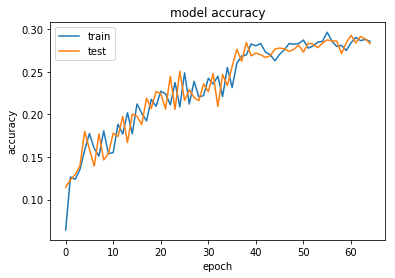

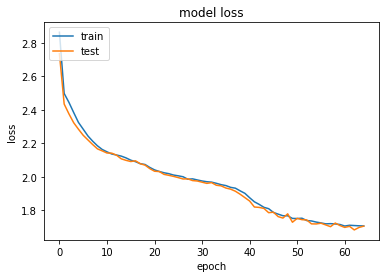

(16, 1, 1)


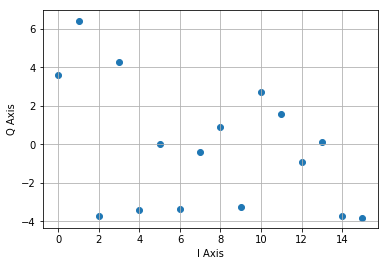

[10.039499]
SNR: 13 SER: 0.655801875 Theor_SER: 0.46240264632309924
(32000, 16)
Train on 22400 samples, validate on 9600 samples
Epoch 1/65
22400/22400 [==============================] - 3s 135us/step - loss: 2.7705 - acc: 0.0828 - val_loss: 2.4109 - val_acc: 0.1415
Epoch 2/65
22400/22400 [==============================] - 0s 3us/step - loss: 2.4037 - acc: 0.1451 - val_loss: 2.1524 - val_acc: 0.1560
Epoch 3/65
22400/22400 [==============================] - 0s 3us/step - loss: 2.1158 - acc: 0.1837 - val_loss: 1.9828 - val_acc: 0.1927
Epoch 4/65
22400/22400 [==============================] - 0s 3us/step - loss: 1.9568 - acc: 0.2147 - val_loss: 1.8754 - val_acc: 0.2264
Epoch 5/65
22400/22400 [==============================] - 0s 3us/step - loss: 1.8784 - acc: 0.2396 - val_loss: 1.8227 - val_acc: 0.2253
Epoch 6/65
22400/22400 [==============================] - 0s 3us/step - loss: 1.8098 - acc: 0.2406 - val_loss: 1.7574 - val_acc: 0.2751
Epoch 7/65
22400/22400 [=============================

Epoch 60/65
22400/22400 [==============================] - 0s 3us/step - loss: 1.3806 - acc: 0.3612 - val_loss: 1.3794 - val_acc: 0.3672
Epoch 61/65
22400/22400 [==============================] - 0s 3us/step - loss: 1.3799 - acc: 0.3671 - val_loss: 1.3660 - val_acc: 0.3633
Epoch 62/65
22400/22400 [==============================] - 0s 3us/step - loss: 1.3771 - acc: 0.3721 - val_loss: 1.3850 - val_acc: 0.3687
Epoch 63/65
22400/22400 [==============================] - 0s 3us/step - loss: 1.3725 - acc: 0.3766 - val_loss: 1.3671 - val_acc: 0.3767
Epoch 64/65
22400/22400 [==============================] - 0s 3us/step - loss: 1.3748 - acc: 0.3641 - val_loss: 1.3525 - val_acc: 0.3822
Epoch 65/65
22400/22400 [==============================] - 0s 3us/step - loss: 1.3741 - acc: 0.3718 - val_loss: 1.3970 - val_acc: 0.3579
Epoch 00065: early stopping
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
32000/32000 [==============================] - 0s 2us/step
test loss, test acc: [1.406757477760315, 

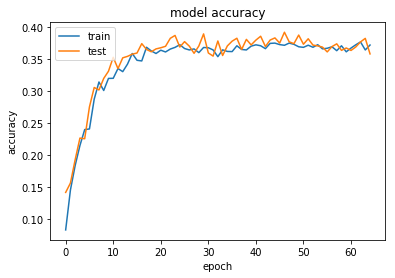

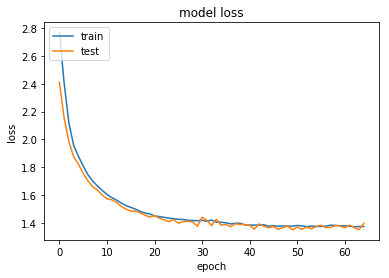

(16, 1, 1)


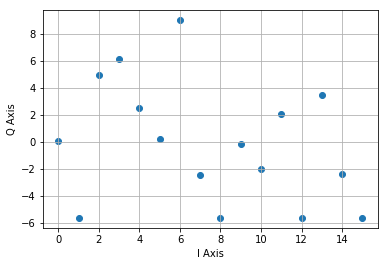

[19.271477]
SNR: 16 SER: 0.601715625 Theor_SER: 0.3123019621637889
(64000, 16)
Train on 44800 samples, validate on 19200 samples
Epoch 1/65
44800/44800 [==============================] - 4s 91us/step - loss: 2.6045 - acc: 0.0893 - val_loss: 2.3567 - val_acc: 0.1242
Epoch 2/65
44800/44800 [==============================] - 0s 4us/step - loss: 2.1885 - acc: 0.1285 - val_loss: 1.9938 - val_acc: 0.1373
Epoch 3/65
44800/44800 [==============================] - 0s 6us/step - loss: 1.9290 - acc: 0.2063 - val_loss: 1.8158 - val_acc: 0.2858
Epoch 4/65
44800/44800 [==============================] - 0s 5us/step - loss: 1.7545 - acc: 0.3136 - val_loss: 1.6960 - val_acc: 0.2651
Epoch 5/65
44800/44800 [==============================] - 0s 5us/step - loss: 1.6015 - acc: 0.3477 - val_loss: 1.5289 - val_acc: 0.3809
Epoch 6/65
44800/44800 [==============================] - 0s 6us/step - loss: 1.4867 - acc: 0.3731 - val_loss: 1.4262 - val_acc: 0.3876
Epoch 7/65
44800/44800 [==============================

Epoch 60/65
44800/44800 [==============================] - 0s 5us/step - loss: 1.0965 - acc: 0.5104 - val_loss: 1.1022 - val_acc: 0.5126
Epoch 61/65
44800/44800 [==============================] - 0s 5us/step - loss: 1.0893 - acc: 0.5146 - val_loss: 1.0724 - val_acc: 0.5191
Epoch 62/65
44800/44800 [==============================] - 0s 5us/step - loss: 1.0841 - acc: 0.5164 - val_loss: 1.0678 - val_acc: 0.5231
Epoch 63/65
44800/44800 [==============================] - 0s 5us/step - loss: 1.0880 - acc: 0.5124 - val_loss: 1.0820 - val_acc: 0.5195
Epoch 64/65
44800/44800 [==============================] - 0s 5us/step - loss: 1.0916 - acc: 0.5143 - val_loss: 1.0667 - val_acc: 0.5236
Epoch 65/65
44800/44800 [==============================] - 0s 5us/step - loss: 1.0831 - acc: 0.5169 - val_loss: 1.0961 - val_acc: 0.5148
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
64000/64000 [==============================] - 0s 4us/step
test loss, test acc: [1.1019999580383302, 0.510453125]


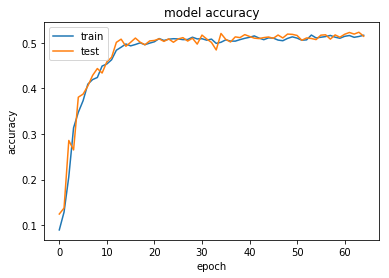

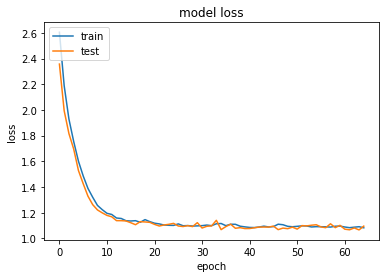

(16, 1, 1)


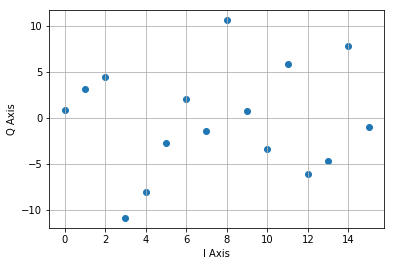

[31.528603]
SNR: 18 SER: 0.421786875 Theor_SER: 0.2091143760439485
(12800, 16)
Train on 8960 samples, validate on 3840 samples
Epoch 1/65
8960/8960 [==============================] - 4s 427us/step - loss: 2.9687 - acc: 0.0699 - val_loss: 2.5511 - val_acc: 0.1341
Epoch 2/65
8960/8960 [==============================] - 0s 5us/step - loss: 2.5719 - acc: 0.1321 - val_loss: 2.5247 - val_acc: 0.1383
Epoch 3/65
8960/8960 [==============================] - 0s 3us/step - loss: 2.4956 - acc: 0.1353 - val_loss: 2.4520 - val_acc: 0.1393
Epoch 4/65
8960/8960 [==============================] - 0s 5us/step - loss: 2.3897 - acc: 0.1323 - val_loss: 2.3502 - val_acc: 0.1625
Epoch 5/65
8960/8960 [==============================] - 0s 3us/step - loss: 2.2883 - acc: 0.1612 - val_loss: 2.1788 - val_acc: 0.1294
Epoch 6/65
8960/8960 [==============================] - 0s 5us/step - loss: 2.1659 - acc: 0.1319 - val_loss: 2.0959 - val_acc: 0.2826
Epoch 7/65
8960/8960 [==============================] - 0s 5us/step

Epoch 61/65
8960/8960 [==============================] - 0s 14us/step - loss: 1.1155 - acc: 0.5067 - val_loss: 1.1182 - val_acc: 0.4919
Epoch 62/65
8960/8960 [==============================] - 0s 9us/step - loss: 1.1074 - acc: 0.5084 - val_loss: 1.1162 - val_acc: 0.4747
Epoch 63/65
8960/8960 [==============================] - 0s 9us/step - loss: 1.0852 - acc: 0.4921 - val_loss: 1.0945 - val_acc: 0.5422
Epoch 64/65
8960/8960 [==============================] - 0s 7us/step - loss: 1.0841 - acc: 0.5439 - val_loss: 1.1142 - val_acc: 0.5076
Epoch 65/65
8960/8960 [==============================] - 0s 7us/step - loss: 1.0777 - acc: 0.5461 - val_loss: 1.0709 - val_acc: 0.5497
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
12800/12800 [==============================] - 0s 6us/step
test loss, test acc: [1.0732445240020752, 0.5475]


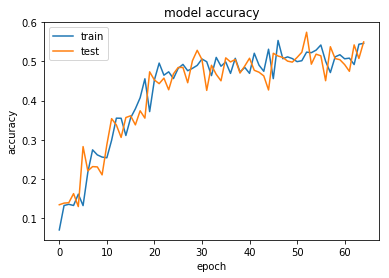

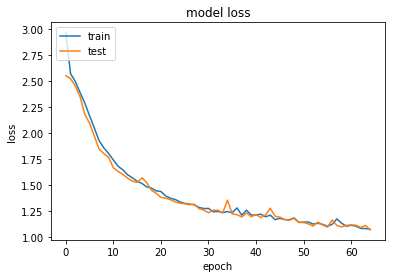

(16, 1, 1)


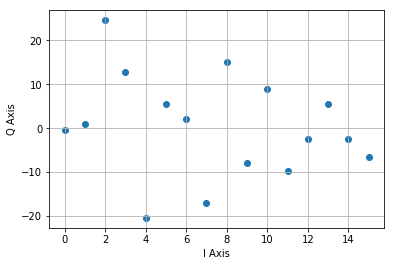

[129.25568]
SNR: 24 SER: 0.43918828125 Theor_SER: 0.014111651848117142
(256000, 16)
Train on 179200 samples, validate on 76800 samples
Epoch 1/65
179200/179200 [==============================] - 5s 29us/step - loss: 2.3525 - acc: 0.1738 - val_loss: 2.0335 - val_acc: 0.2482
Epoch 2/65
179200/179200 [==============================] - 1s 4us/step - loss: 1.8932 - acc: 0.2628 - val_loss: 1.7903 - val_acc: 0.3240
Epoch 3/65
179200/179200 [==============================] - 1s 4us/step - loss: 1.7437 - acc: 0.3532 - val_loss: 1.7649 - val_acc: 0.2853
Epoch 4/65
179200/179200 [==============================] - 1s 4us/step - loss: 1.5370 - acc: 0.3675 - val_loss: 1.3624 - val_acc: 0.4743
Epoch 5/65
179200/179200 [==============================] - 1s 5us/step - loss: 1.3038 - acc: 0.4938 - val_loss: 1.2208 - val_acc: 0.5754
Epoch 6/65
179200/179200 [==============================] - 1s 5us/step - loss: 1.1628 - acc: 0.5484 - val_loss: 1.0929 - val_acc: 0.6009
Epoch 7/65
179200/179200 [==========

179200/179200 [==============================] - 1s 4us/step - loss: 0.7101 - acc: 0.6755 - val_loss: 0.7330 - val_acc: 0.6634
Epoch 60/65
179200/179200 [==============================] - 1s 4us/step - loss: 0.6899 - acc: 0.6832 - val_loss: 0.6676 - val_acc: 0.6976
Epoch 61/65
179200/179200 [==============================] - 1s 4us/step - loss: 0.6778 - acc: 0.6898 - val_loss: 0.6451 - val_acc: 0.7099
Epoch 62/65
179200/179200 [==============================] - 1s 4us/step - loss: 0.6598 - acc: 0.7010 - val_loss: 0.6410 - val_acc: 0.7117
Epoch 63/65
179200/179200 [==============================] - 1s 4us/step - loss: 0.6481 - acc: 0.7057 - val_loss: 0.6382 - val_acc: 0.7115
Epoch 64/65
179200/179200 [==============================] - 1s 4us/step - loss: 0.6582 - acc: 0.6996 - val_loss: 0.6416 - val_acc: 0.7087
Epoch 65/65
179200/179200 [==============================] - 1s 4us/step - loss: 0.6642 - acc: 0.6967 - val_loss: 0.6536 - val_acc: 0.7037
dict_keys(['val_loss', 'val_acc', 'loss

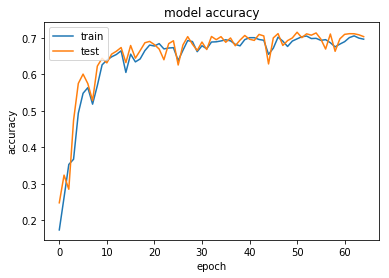

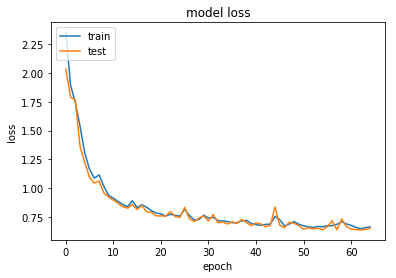

(16, 1, 1)


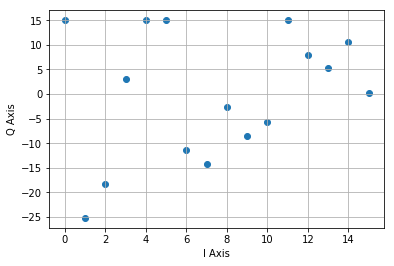

[158.03613]


In [ ]:
# Calculating SER from -4dB to 14dB SNR
EsNodB_range = [0,6,12,13,16,18,24,25]
N_array = [20000,40000,80000,160000,320000,640000,128000,2560000]
ser = [None]*len(EsNodB_range)
theor_ser = [None]*len(EsNodB_range)

for n in range(0,len(EsNodB_range)):
    
    
    EsNo=10.0**(EsNodB_range[n]/10.0)
    P = EsNo*(noise_std**2)
    no_errors = 0
    
    N = int(N_array[n]/10)
    autoencoder = set_up_train_nn(P,EsNodB_range[n])
    N=N*100
        
    test_data = []
    test_label = np.random.randint(M,size=N)
    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    pred_output = np.argmax(pred_final_signal,axis=1)
    
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser[n] = (no_errors/N).astype('float64') 
    
    theor_ser[n] = (15/16)*special.erfc(np.sqrt(EsNo/85))
    
    print ('SNR:',EsNodB_range[n],'SER:',ser[n],'Theor_SER:',theor_ser[n])

In [ ]:
# ploting BER curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EsNodB_range, theor_ser, 'k^-',label='16 PAM')
plt.plot(EsNodB_range, ser, 'b^-',label='Autoencoder')
plt.yscale('log')
plt.xlabel('Es/No(dB)')
plt.ylabel('Symbol Error Rate')
#plt.ylim((10e-3,10e0))
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()